# An Introduction to Bayesian Optimization I: Gaussian Process Regression

_Prepared by Ritz Aguilar for Thrill Summer School at Toulon, France, October 2024_

#### Objectives
- Introduce the fundamental concepts and purpose of Bayesian Optimization (BO).
- Learn about surrogate models for BO, specifically Gaussian Processes.
- Learn some of the acquisition/utility functions used in BO.

#### Definition
**Bayesian Optimization** is a global optimization method used for optimizing black-box functions that are expensive to evaluate, common in control and machine learning applications.


- **Problem**: We have an objective function $f(x)$, but we don't know its form and each evaluation is costly and/or noisy as in real-world problems. Our goal is to find the minimum of this noisy function: 
\begin{align}x^* = arg \min_x f(x).\end{align}

- **Solution**: Use a probabilistic surrogate model (e.g., Gaussian Process) to approximate $f(x)$ and an acquisition function to decide where to evaluate next.


#### Key Components
1. **Objective Function**: The ground truth function we want to learn/optimize. This is an unknown function, i.e. a black-box.
2. **Surrogate Model**: Estimates the objective function by using a surrogate model, i.e. a probabilistic model. _**Gaussian Processes (GP)**_ are often used as they provide both mean prediction and uncertainty for each point.
3. **Acquisition/Utility Functions**: Serves as a guide for deciding which point in the search space to evaluate next based on the current model of the objective function.

##### Set up the environment; import all libraries

In [1]:
## Uncomment to install the following library in your environment
# !pip install scikit-learn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

## Gaussian Processes (GP) Regression

#### Exercise 1: GP Fitting

We will fit a GP to an objective function $f(x)$ and visualize the predictions. 

#### Define the objective function we want to optimize

In [3]:
np.random.seed(42)

noise_level = 0.25
def f(x, noise_level=noise_level):
    return -np.exp(-x) * np.sin(4 * x) + np.random.randn(*x.shape) * noise_level

In [4]:
# Define input range for plotting the objective function f
bounds = np.array([[-2.0, 2.0]])
X = np.linspace(bounds[:, 0], bounds[:, 1], 100).reshape(-1, 1)
Y = f(X, noise_level=0)

#### Create training data

Let's say our training data has 5 initial samples (observations).

In [5]:
X_init = np.random.uniform(bounds[:, 0], bounds[:, 1], 3).reshape(-1, 1)
Y_init = f(X_init)
print(Y_init.shape)

(3, 1)


We then plot the ground truth (objective) function without noise, the noisy samples, and the initial observation points.

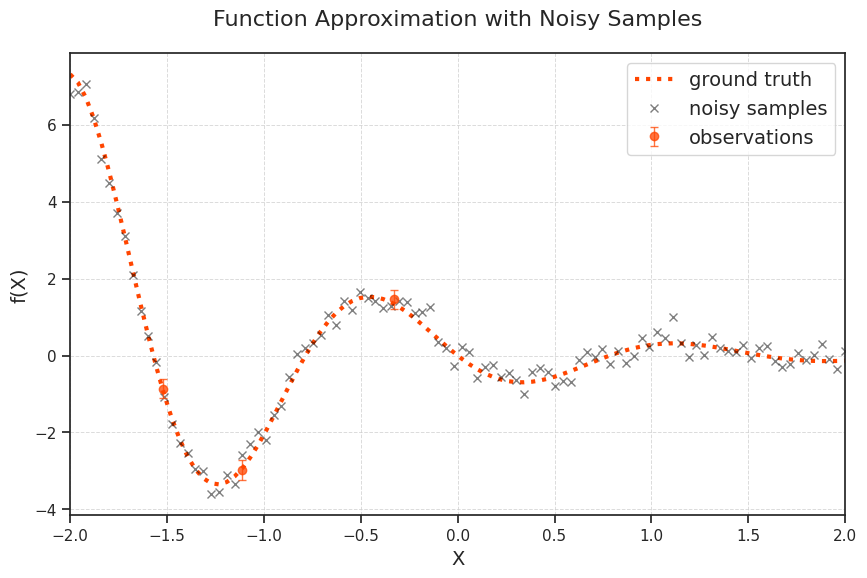

In [6]:
sns.set_style("ticks")
sns.set_context("notebook")

plt.figure(figsize=(10, 6))
plt.plot(X, Y, c='#FF4500', ls=':', lw=3, label=r'ground truth') 
plt.plot(X, f(X, noise_level), c='k', marker='x', alpha=0.5, ms=6, ls='', label='noisy samples')
plt.errorbar(X_init.flatten(), Y_init.flatten(), yerr=noise_level, 
             c='#FF4500', fmt='.', ms=12, capsize=3, elinewidth=1,  alpha=0.75, label='observations', )  

plt.title("Function Approximation with Noisy Samples", fontsize=16, pad=20)
plt.xlim([bounds[:,0], bounds[:,1]])
plt.xlabel("X", fontsize=14)
plt.ylabel("f(X)", fontsize=14)
plt.legend(loc="upper right", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

Now, we sample points from the objective function which is unknown to us. In the lab, we can only measure a few points (often noisy) and infer the unknown function from points (priors).

Define a GP model with the combined effect of multiple kernels and then fit the model to the sampled data. Here, we use the default combination of a Constant kernel and Radial Basis Function (RBF) kernel.

In [7]:
# Define the kernel: Constant kernel * RBF kernel
kern_crbf = C(1.0) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
kern_cm = C(1.0) * Matern(length_scale=1.0, nu=2.5)

# Use GP as a surrogate model
gp = GaussianProcessRegressor(kernel=kern_cm, n_restarts_optimizer=9, alpha=noise_level**2)

# Fit the GP model to your training data
gp.fit(X_init, Y_init)

GaussianProcessRegressor(alpha=0.0625,
                         kernel=1**2 * Matern(length_scale=1, nu=2.5),
                         n_restarts_optimizer=9)

#### Predict over the specified input range for plotting the objective function

In [8]:
# # Predict at new data points
# X_new = np.linspace(-2, 2, 100).reshape(-1, 1)
Y_pred, sigma = gp.predict(X, return_std=True)

Above: _Y_pred_ is the mean prediction and _sigma_ would be the standard deviation.

#### Plot the result for a single iteration

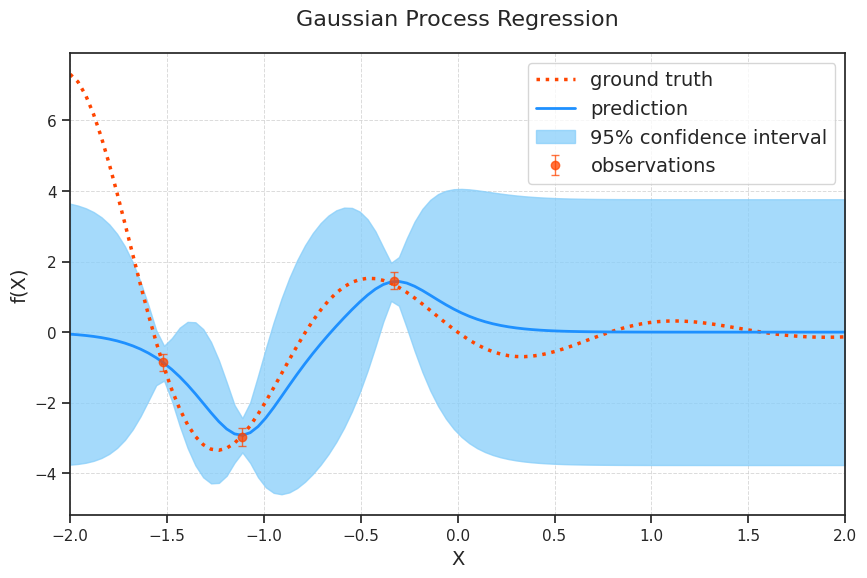

In [9]:
# Plotting the GP predictions
plt.figure(figsize=(10, 6))

plt.plot(X, Y, c='#FF4500', ls=':', lw=2.5, label=r'ground truth')
plt.errorbar(X_init.flatten(), Y_init.flatten(), yerr=noise_level, 
             c='#FF4500', fmt='.', ms=12, capsize=3, elinewidth=1, alpha=0.75, label='observations', )  
plt.plot(X, Y_pred, c='#1E90FF', lw=2, label='prediction')  
plt.fill_between(X.ravel(), 
                 Y_pred - 1.96 * sigma, 
                 Y_pred + 1.96 * sigma, 
                 color='#87CEFA', alpha=0.75, label='95% confidence interval')

plt.title("Gaussian Process Regression", fontsize=16, pad=20)
plt.xlim([bounds[:,0], bounds[:,1]])
plt.xlabel("X", fontsize=14)
plt.ylabel("f(X)", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(loc='upper right', fontsize=14)

plt.show()

**Exercise 1.1** Adjust the number of observation data points to see how it affects the GP’s confidence.

##### Sol 1.1

**Exercise 1.2** Play around with different noise levels and see how it affects the measured value.

##### Sol 1.2

#### Exercise 2: Bayesian Optimization Loop

To optimize the objective function iteratively, we follow the steps outlined below for $t = 1, 2, \ldots, T$:

1. **Construct a Probabilistic Model**: Start with the observations $x_i, y_i = f(x_i)$ for $i = 1:t$ to build a probabilistic model of the objective function $f$. This involves integrating over all possible true functions using GP regression.

2. **Select the Next Sampling Point**: Choose the next point to sample, $x_{t+1}$, by finding the maximum of the _acquisition function_ $u$ based on the current observations:
   $x_{t+1} = \arg \max_x u(x)$.
   This step helps balance exploration and exploitation by leveraging uncertainty in the model.

3. **Sample the Objective Function**: Evaluate the objective function at the selected point, obtaining $y_{t+1} = f(x_{t+1})$. Add this new observation to the existing dataset.

4. **Update the Surrogate Model**: Update the surrogate function $g(\cdot)$ to incorporate the newly sampled point $(x_{t+1}, y_{t+1})$.

References: 
1. https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html
2. https://sassafras13.github.io/BayesianOptimization/

#### Define the Acquisition Function

One of the most commonly used acquisition functions used in BO is *Expected Improvement (EI)*, which we will first briefly look into. A deeper dive into these acquisition functions will be discussed in Part II.

EI measures the expected amount of improvement over the best-observed value so far during GP regression, balancing both uncertainty and the predicted value. It is formulated as [Adapted from https://github.com/krasserm/bayesian-machine-learning]:

$$\mathrm{EI}(\mathbf{x}) = \mathbb{E}\max(f(\mathbf{x}) - f(\mathbf{\hat{x}}), 0),\tag{1}$$

where $f(\mathbf{\hat{x}})$ represents the value of the current best sample observed, and $\mathbf{\hat{x}}$ denotes the position of that sample, defined as $\mathbf{\hat{x}} = \mathrm{argmax}_{\mathbf{x}_i \in \mathbf{x}_{1:t}} f(\mathbf{x}_i)$. Under GP, this can be calculated analytically as<sup>[3]</sup>:

$$
\mathrm{EI}(\mathbf{x}) =
\begin{cases}
\left[\left(\mu(\mathbf{x}) - f(\mathbf{\hat{x}}) - \xi\right)\Phi(Z)\right] + \left[\sigma(\mathbf{x})\phi(Z)\right]  & \text{if}\ \sigma(\mathbf{x}) > 0, \\
0 & \text{if}\ \sigma(\mathbf{x}) = 0.
\end{cases}\tag{2}
$$

Here,

$$
Z =
\begin{cases}
\dfrac{\mu(\mathbf{x}) - f(\mathbf{\hat{x}}) - \xi}{\sigma(\mathbf{x})} & \text{if}\ \sigma(\mathbf{x}) > 0, \\
0 & \text{if}\ \sigma(\mathbf{x}) = 0,
\end{cases}
$$

where $\mu(\mathbf{x}$ and $\sigma(\mathbf{x})$ are the mean and standard deviation of the GP's posterior predictive distribution at the point $\mathbf{x}$, respectively, while $\Phi$ and $\phi$ denote the cumulative distribution function (CDF) and probability density function (PDF) of the standard normal distribution, respectively. The first grouped term containing the CDF in the first case in Eq. (2) reflects the exploitation aspect, while the second term with the PDF pertains to exploration.

The parameter $\xi$ in Eq. (2) governs the exploration during the optimization process; larger values of $\xi$ encourage greater exploration. Specifically, as $\xi$ increases, the influence of potential improvements indicated by the GP's posterior mean $\mu(\mathbf{x})$ diminishes relative to the significance of potential gains in areas of high uncertainty, which are indicated by larger $\sigma(\mathbf{x})$ values. 

In [10]:
from scipy.stats import norm

def expected_improvement(X, X_train, Y_train, gp, xi=0.01):
    '''
    Adapted from https://github.com/krasserm/bayesian-machine-learning
    
    Calculates the Expected Improvement (EI) at points X based on
    existing training data (X_train, Y_train) using a Gaussian process surrogate model.
    
    Args:
        X: Locations where EI will be evaluated (m x d).
        X_train: Training data input points (n x d).
        Y_train: Corresponding observed values for training data (n x 1).
        gp: Trained GaussianProcessRegressor model.
        xi: Parameter that balances exploration and exploitation.

    Returns:
        Computed Expected Improvement values at locations X.
        
    '''
    mu, sigma = gp.predict(X, return_std=True)  # Predict mean and standard deviation
    mu_train = gp.predict(X_train)
    sigma = sigma.reshape(-1, 1)  # Ensure sigma is reshaped as a column vector
    # print("mu, sigma:", mu.shape, sigma.shape)
    
    # For noise models or use np.max(Y_train) for noiseless scenarios
    mu_train_opt = np.max(mu_train) # Best-observed value so far

    with np.errstate(divide='warn'):  # Safe handling division by zero
        imp = mu - mu_train_opt - xi  # Improvement over the best observed value
        Z = imp / sigma.flatten()  # Z-score calculation
        # ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)  # Compute Expected Improvement
        # ei[sigma.flatten() == 0.0] = 0.0  # Set EI to zero where variance is zero
    
        ei = np.where(sigma.flatten() > 0, 
              imp * norm.cdf(Z) + sigma.flatten() * norm.pdf(Z), 
              0)  # Compute Expected Improvement

    # print("ei.shape:", ei.shape)
    return ei.flatten()

Note: The parameter $\xi$ is to $0.01$ above as a default as it is commonly used in most literatures.

In [11]:
from scipy.optimize import minimize

def propose_location(acquisition, X_train, Y_train, gp, bounds, n_restarts=25):
    '''
    Adapted from https://github.com/krasserm/bayesian-machine-learning
    
    Suggests the next point to sample by optimizing the acquisition function.
    
    Args:
        acquisition: The acquisition function to be maximized.
        X_train: Training data input points (n x d).
        Y_train: Observed values corresponding to training points (n x 1).
        gp: A trained GaussianProcessRegressor model.
        bounds: Boundaries for the search space.
        n_restarts: Number of random starting points for optimization.

    Returns:
        The proposed next sampling location.
    '''
    dim = X_train.shape[1]
    min_val = 1  # Initialize with a large value
    min_x = None  # Placeholder for the optimal point
    
    def min_obj(X):
        # Objective to minimize: negative of the acquisition function
        return -acquisition(X.reshape(-1, dim), X_train, Y_train, gp).flatten()
    
    # Search for the optimal point by trying multiple random n_restart points
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x

    return min_x.reshape(-1, 1)

We also put all the plotting into functions for convenience.

In [12]:
def plot_prediction(ax, gp, X, Y, X_train, Y_train, X_next=None, show_legend=False):
    """
    Plot the Gaussian Process predictions with uncertainty intervals,
    training points, and the next proposed sampling point.
    """
    Y_pred, sigma = gp.predict(X, return_std=True)
    ax.fill_between(X.ravel(), 
                    Y_pred - 1.96 * sigma, 
                    Y_pred + 1.96 * sigma, 
                    color='#87CEFA', alpha=0.75, label='95% confidence interval')
    ax.plot(X, Y, c='#FF4500', ls=':', lw=1, label=r'ground truth')
    ax.plot(X, Y_pred, c='#1E90FF', lw=1, label='prediction') 
    ax.errorbar(X_train.flatten(), Y_train.flatten(), yerr=noise_level, 
                c='#FF4500', fmt='.', ms=12, capsize=5, elinewidth=2,  alpha=0.75, label='observations')  
    # ax.set_xlim([bounds[:,0], bounds[:,1]])
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
    
    if X_next:
        ax.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        ax.legend(loc="upper right")

def plot_utility(ax, X, Y, X_next, show_legend=False):
    """
    Plot the utility (acquisition) function and the next proposed sampling point.
    """
    ax.clear()  # Clear the current axes before plotting
    ax.plot(X, Y, 'r-', lw=1, label='utility function')
    ax.fill_between(X.ravel(), Y.ravel(), color='red', alpha=0.3)
    ax.axvline(x=X_next, ls='--', c='k', lw=1, label='proposed next location')
    ax.set_xlim([bounds[:,0], bounds[:,1]])
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
    
    if show_legend:
        ax.legend(loc="lower left")
        
def plot_convergence(ax, X_train, Y_train, n_init=2, show_legend=False):
    """
    Plot convergence metrics: distance between consecutive x's and the best observed Y value.
    """
    # Reshape X_train and Y_train
    x = X_train[n_init:].ravel()
    y = Y_train[n_init:].ravel()
    r = range(1, len(x) + 1)
    
    # Distance between consecutive x's
    x_neighbor_dist = [np.abs(a - b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)
    
    # Create subplots for distance and best Y values
    ax[0].plot(r[1:], x_neighbor_dist, 'bo-')
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('Distance')
    ax[0].set_title('Distance between consecutive x\'s')
    ax[0].grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    # Plot best Y values
    ax[1].plot(r, y_max_watermark, 'ro-', label='Best Y value')
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Best Y')
    ax[1].set_title('Value of best selected sample')
    ax[1].grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    if show_legend:
        ax[1].legend(loc="upper left")
    
    plt.tight_layout()

We now do our BO loop over the 10 iterations.

Iteration 1	 X_next_value: [[-0.09801724]]
Iteration 2	 X_next_value: [[-0.48741728]]
Iteration 3	 X_next_value: [[2.]]
Iteration 4	 X_next_value: [[-0.39926809]]
Iteration 5	 X_next_value: [[1.03027924]]
Iteration 6	 X_next_value: [[0.57564082]]
Iteration 7	 X_next_value: [[-0.39962543]]
Iteration 8	 X_next_value: [[1.4341162]]
Iteration 9	 X_next_value: [[-0.40035368]]
Iteration 10	 X_next_value: [[-0.39653404]]


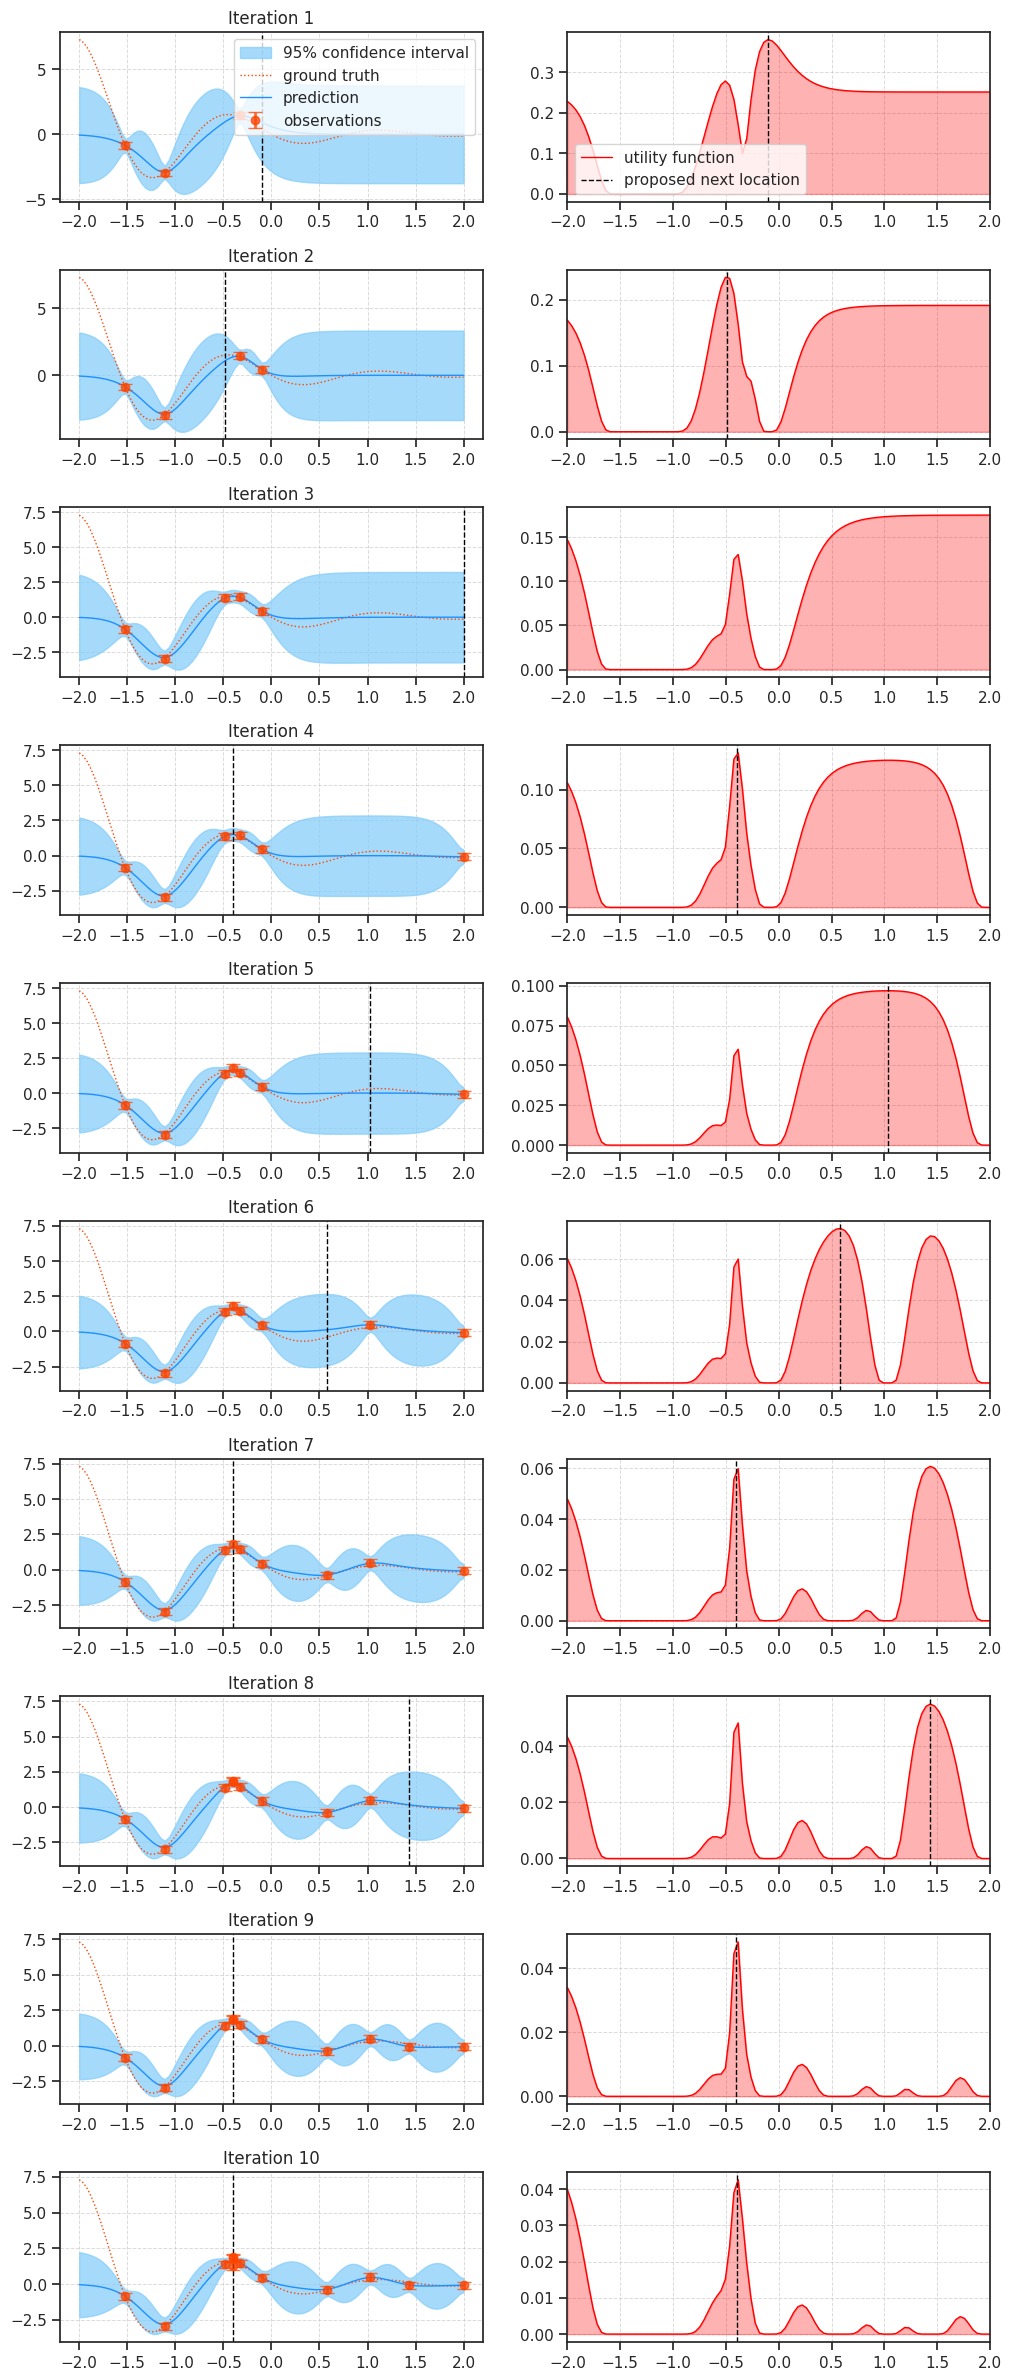

In [13]:
# Number of iterations
n_iter = 10

X_train = X_init
Y_train = Y_init

fig, axes = plt.subplots(n_iter, 2, figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update the Gaussian process with the current training data
    gp.fit(X_train, Y_train)

    # Suggest the next sampling point using the acquisition function (Expected Improvement)
    X_next = propose_location(expected_improvement, X_train, Y_train, gp, bounds)
    print(f'Iteration {i+1}\t X_next_value: {X_next}')
    # Obtain the next (possibly noisy) sample from the objective function
    Y_next = f(X_next, noise_level)
    
    # Plot the GP approximation, noisy samples, and the next sampling point
    plot_prediction(axes[i, 0], gp, X, Y, X_train, Y_train, X_next, show_legend=(i == 0))
    axes[i, 0].set_title(f'Iteration {i+1}')

    # print("X.shape",X.shape,"X_train.shape",X_train.shape,"Y_train.shape:",Y_train.shape)
    # Plot the acquisition (utility) function and the proposed next sample
    ei_values = expected_improvement(X, X_train, Y_train, gp)
    # print("ei_values.shape")
    plot_utility(axes[i, 1], X, ei_values, X_next, show_legend=(i == 0))

    # Add the new sample to the training set
    X_train = np.vstack((X_train, X_next))
    Y_train = np.vstack((Y_train, Y_next))

#### Plot convergence

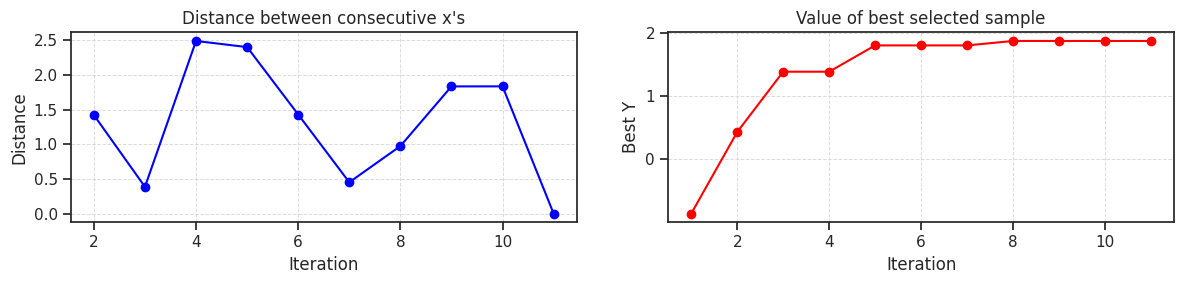

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))  # Create subplots
plot_convergence(ax, X_train, Y_train)
plt.show()  # Display the plots

### Using other libraries

In [15]:
# We first put everything together and neatly into functions.

def objective_function():
    kernel = C(params[0], (1e-3, 1e3)) * RBF(params[1], (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(X_train, y_train)
    predictions = gp.predict(X_test)
    return -mean_squared_error(y_test, predictions)

kernel = C(1.0) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

# Fit the GP model to the sampled data
gp.fit(X, Y)

GaussianProcessRegressor(alpha=0.01, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

## Applications

Laser Control and Diagnostics
SVM, contour plots

## Extensions

There are other Python-based libraries offering more streamlined approaches to perform BO. These include:
- $\texttt{skopt}$ - built on top of $\texttt{numpy}$, $\texttt{scipy}$, and $\texttt{scikit-learn}$
- $\texttt{bayesian-optimization}$ - pure Python implementation of BO with GP
- $\texttt{GPy}$
- $\texttt{gpax}$ - built on top of $\texttt{NumPyro}$ and $\texttt{JAX}$, allows for running on GPU; better to create a new environment for this one

In [16]:
# !pip install bayesian-optimization

### References

1. [F. Nogueira (2014), Bayesian Optimization: Open source constrained global optimization tool for Python](https://bayesian-optimization.github.io/BayesianOptimization)
2. [E. Lee (2023), Bayesian Optimization with Python](https://drlee.io/bayesian-optimization-with-python-b544255757d3)
3. [S. V. Kalinin (2023), Bayesian Optimization for Automated Experiments](https://github.com/SergeiVKalinin/AutomatedExperiment_Summer2023)
4. https://distill.pub/2020/bayesian-optimization/
5. https://nbviewer.org/github/krasserm/bayesian-machine-learning/blob/dev/bayesian-optimization/bayesian_optimization.ipynb